In [1]:
#import libraries and dependencies
import pandas as pd
import yfinance as yf
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from scipy import stats
import datetime as dt
from sklearn import linear_model
from pandas import Timestamp
from scipy.stats import linregress

pd.set_option('display.max_columns', None)


In [2]:
# Step 1: Choose an ETF and identify assets
df_spy=pd.read_excel('https://www.ssga.com/us/en/institutional/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx',header=4)
etf_ticker=df_spy['Ticker'].dropna().to_list() #identifying the assets inside the s&p500

# Step 2: Retrieve historical data for the ETF
historical_data = yf.download(etf_ticker, period='1y') #looks good


[*********************100%%**********************]  504 of 504 completed


3 Failed downloads:
['BRK.B', '-']: Exception('%ticker%: No data found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=1y)')


In [3]:
# Step 3: Calculate the price momentum factors
# Here, we use a simple 1-month rate of change

#Calculating the 1st factor (52 week trend line)
HIST_DATA=historical_data[historical_data.columns].pct_change(periods=20).dropna(how='all',axis=0) #George's Idea
HIST_DATA=HIST_DATA.drop(HIST_DATA.columns[0],axis=1)['Adj Close'] #first column is all NAN's

#Trend line (slope) for 1 asset "AAL"  credit: https://stackoverflow.com/questions/53100393/how-to-get-slope-from-timeseries-data-in-pandas
# https://www.appsloveworld.com/pandas/100/13/how-to-get-slope-from-timeseries-data-in-pandas?expand_article=1    
# Extract numeric representation of dates for linear regression
def getslope(data):
    x_values = np.arange(len(data.index.values))
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x_values, data)
    
    return slope#Thanks to ChatGPT for helping me get the slope as i did not know how to do it for a time series data

#now lets get the slope for all the assets
#getslope(HIST_DATA['AAL']) test case

slopes=HIST_DATA.apply(getslope) #it's rounding but that's fine
#HIST_DATA['AAL'].plot(kind='line') #plot of 1 trend line 


#Step 4:
slopes=slopes.dropna() #the nans need to be removed
assets_Zscores=zscore(slopes) #get the Z score
#assets_Zscores Always nice to take a quick look

#Step 5: Identify baskets (I Think it works)
#resource: https://www.freshbooks.com/glossary/financial/z-score#:~:text=What%20Is%20a%20Good%20Z,considered%20above%20the%20standard%20score.
#I'll define my boundary at 3 and even though i hate shorting stocks but for this project we will short those under 1.8
#link: https://www.investopedia.com/terms/a/altman.asp#:~:text=A%20score%20below%201.8%20signals,value%20is%20closer%20to%201.8.
buy=assets_Zscores[assets_Zscores>1.8]
short=assets_Zscores[assets_Zscores<1.8]

C:\Users\georg\AppData\Local\Temp\ipykernel_30792\2418598618.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  HIST_DATA=historical_data[historical_data.columns].pct_change(periods=20).dropna(how='all',axis=0) #George's Idea


In [4]:
#Step 6: Back test 
#To run this for 5 years we can get the data for all of our assets for the last 5 years and for each of the 60 months buy the suggested stock
#to see it's returns for those  periods

historical_data = yf.download(etf_ticker, start='2018-01-01', end='2023-01-01')
historical_data=historical_data['Adj Close'].drop(columns='-')

#Calculating the 1st factor (52 week trend line)
HIST_DATA=historical_data[historical_data.columns].pct_change(periods=20).dropna(how='all',axis=0)
assets_Zscores=zscore(HIST_DATA.apply(getslope).dropna()) #get the Z score
buy=assets_Zscores[assets_Zscores>1.8]
short=assets_Zscores[assets_Zscores<1.8]
buynow=buy[0:15] #lets buy this on january first and see how much we would have made
shortnow=short[0:10] #We can short these

[*********************100%%**********************]  504 of 504 completed


5 Failed downloads:
['BRK.B', '-']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2018-01-01 -> 2023-01-01)')
['VLTO', 'KVUE']: Exception("%ticker%: Data doesn't exist for startDate = 1514782800, endDate = 1672549200")


C:\Users\georg\AppData\Local\Temp\ipykernel_30792\2195580533.py:9: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  HIST_DATA=historical_data[historical_data.columns].pct_change(periods=20).dropna(how='all',axis=0)


In [11]:
#STEPS 6 & 7 NO IDEA WHAT TO DO NOW

#Step 6: range is 60 because every i will represent 1 month and there are 60 months in 5 years
#lets look at the last 20 trading days then buy assets based on those days then hold them for a month before restructuring 
profit=0
earnings=[]
losses=[]
totals=[]
for i in range(60):
    assets_Zscores=zscore(HIST_DATA.iloc[i*20:(i+1)*20].apply(getslope).dropna())
    buy=assets_Zscores[assets_Zscores>1.8]
    short=assets_Zscores[assets_Zscores<1.8]
    buy=buy.index.to_list()
    short=short.index.to_list()
    HIST_DATA.iloc[(i+1)*20:(i+2)*20] #we baughgt it now lets see our gains
    profit_from_buy=sum((historical_data[buy].iloc[(i+1)*20:(i+2)*20].dropna(how='all',axis=1).iloc[19]-historical_data[buy].iloc[(i+1)*20:(i+2)*20].dropna(how='all',axis=1).iloc[0]).dropna().to_list())
    profit_from_short=-sum((historical_data[short].iloc[(i+1)*20:(i+2)*20].dropna(how='all',axis=1).iloc[19]-historical_data[short].iloc[(i+1)*20:(i+2)*20].dropna(how='all',axis=1).iloc[0]).dropna().to_list())
    profit+=profit_from_buy
    profit+=profit_from_short
    earnings.append(profit_from_buy)
    losses.append(profit_from_short)
    totals.append(profit)

    

In [ ]:
#i=2
#sum((historical_data[].iloc[(i+1)*20:(i+2)*20].dropna(how='all',axis=1).iloc[19]-historical_data[].iloc[(i+1)*20:(i+2)*20].dropna(how='all',axis=1).iloc[0]).dropna().to_list())

In [ ]:
sum(a.dropna().to_list())

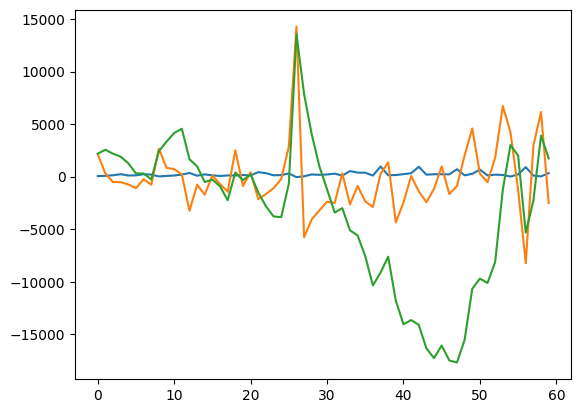

In [13]:
import matplotlib.pyplot as plt
plt.plot(earnings) #earnings over 5 years (I know its wrong i dont have much else) Note: these are the buy returns
plt.plot(losses)
plt.plot(totals)

<BarContainer object of 60 artists>

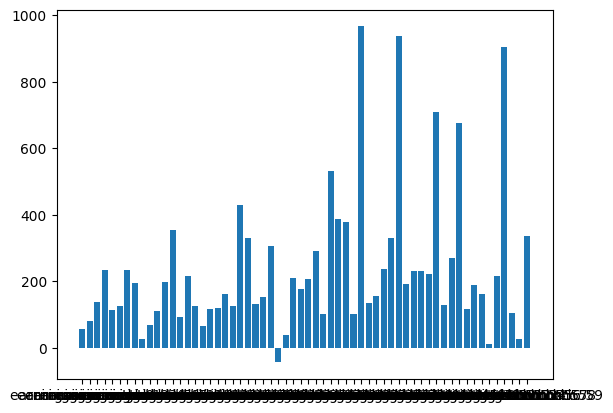

In [25]:
#we can also do a bar char
pro=[]
e=[str(i) for i in range(len(earnings))]
for i in range(len(earnings)):
    pro.append('earnings in month: '+str(i))
plt.bar(pro,earnings)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59]